In [ ]:
!pip install polyglot

In [ ]:
!pip install icu

In [ ]:
!pip install selenium

In [ ]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import requests
from bs4 import BeautifulSoup
import json
from collections import Counter
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import re
import nltk
nltk.download('wordnet')


from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
figsize = (15, 10)
lemma = nltk.wordnet.WordNetLemmatizer()

# Scraping Web Sugar
url = 'https://www.indexmundi.com/commodities/?commodity=sugar&months=360'
page = requests.get(url)

soup = BeautifulSoup(page.content)

# Scraping data table from the web
table = soup.find_all('table', {'class': 'tblData'})

df_table = pd.DataFrame()
df_month = pd.DataFrame()
df_price = pd.DataFrame()
df_change = pd.DataFrame()

for kolom in table:
    rows = kolom.find_all('tr')
    res = []
    for tr in rows:
        td = tr.find_all('td')
        row = [tr.text.strip() for tr in td if tr.text.strip()]
        if row:
            res.append(row)

    arr_month = []
    arr_price = []
    arr_change = []

    for data in res:
        arr_month.append(data[0])
        arr_price.append(data[1])
        arr_change.append(data[2])

    df_month = pd.concat([df_month, pd.DataFrame({'month': arr_month})], ignore_index=True)
    df_price = pd.concat([df_price, pd.DataFrame({'price': arr_price})], ignore_index=True)
    df_change = pd.concat([df_change, pd.DataFrame({'change': arr_change})], ignore_index=True)

df_table = pd.concat([df_month, df_price, df_change], axis=1)

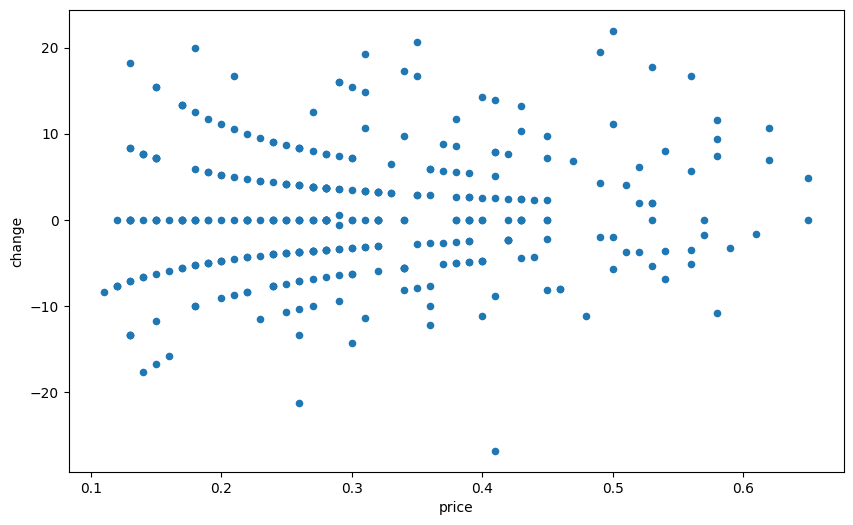

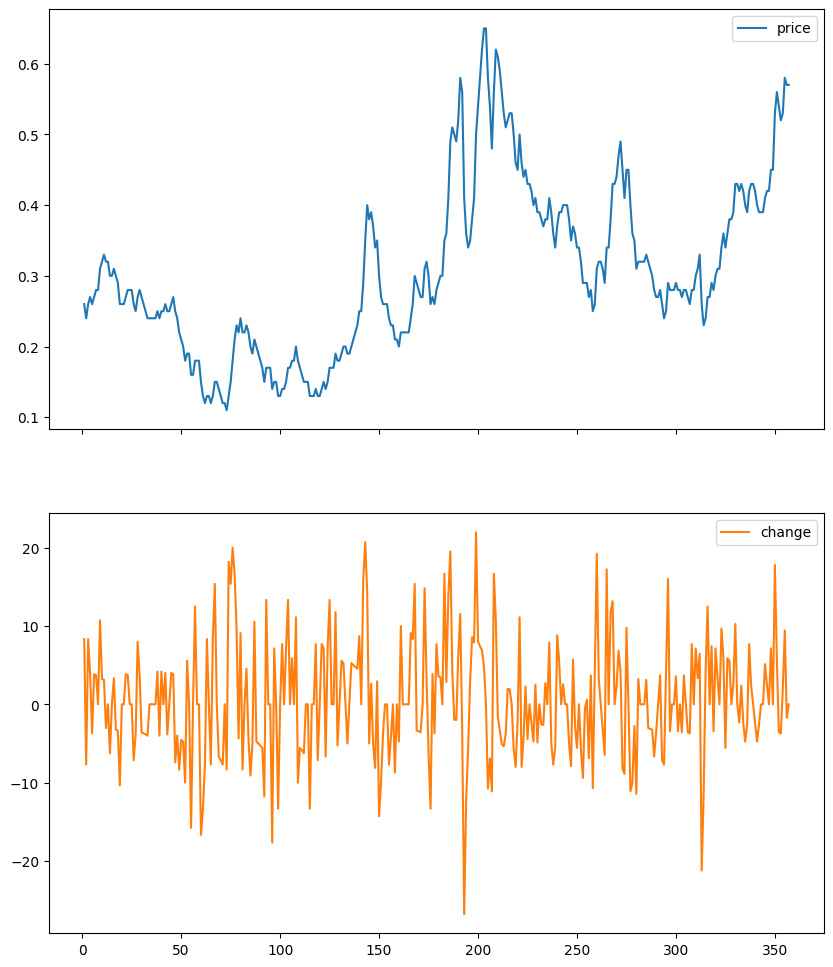

In [ ]:
# Exploratory Data Analysis (EDA)
df_eda = df_table[1:].copy()
df_eda['price'] = df_eda['price'].astype(float)
df_eda['change'] = df_eda['change'].str.rstrip('%').astype('float')

# Visualizations
df_eda.plot.scatter(x='price', y='change', figsize=(10, 6))
df_eda.plot(subplots=True, figsize=(10, 12))

# Visualizations by month
df_eda['month'] = pd.to_datetime(df_eda['month'])

<Axes: xlabel='month', ylabel='Resid'>

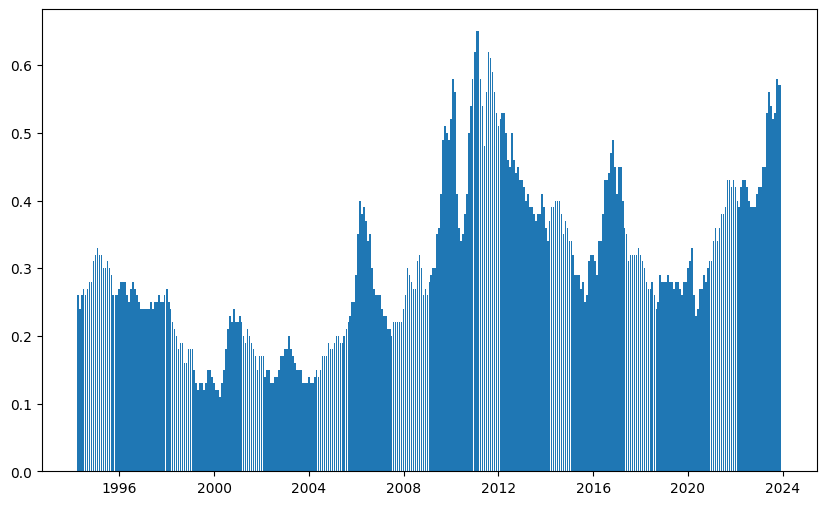

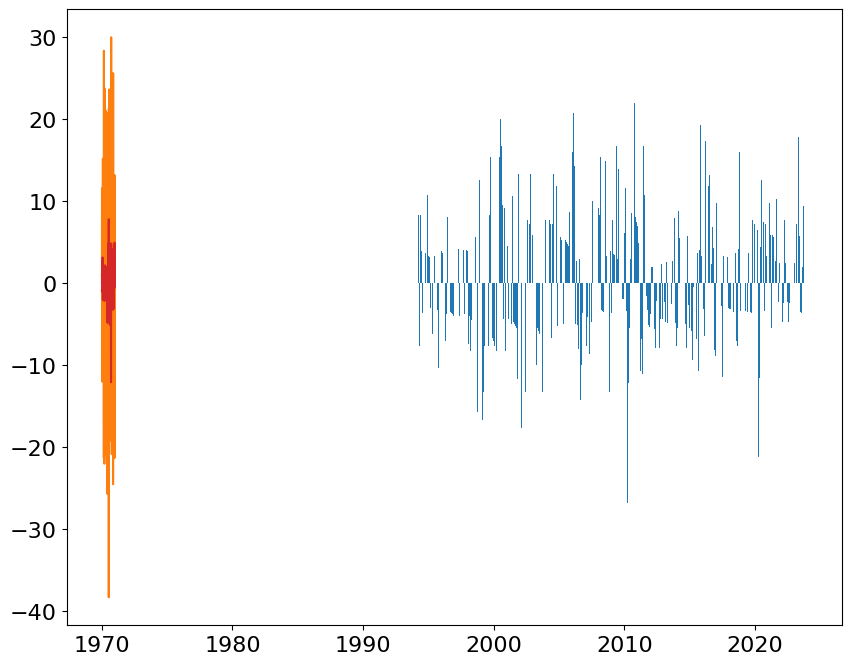

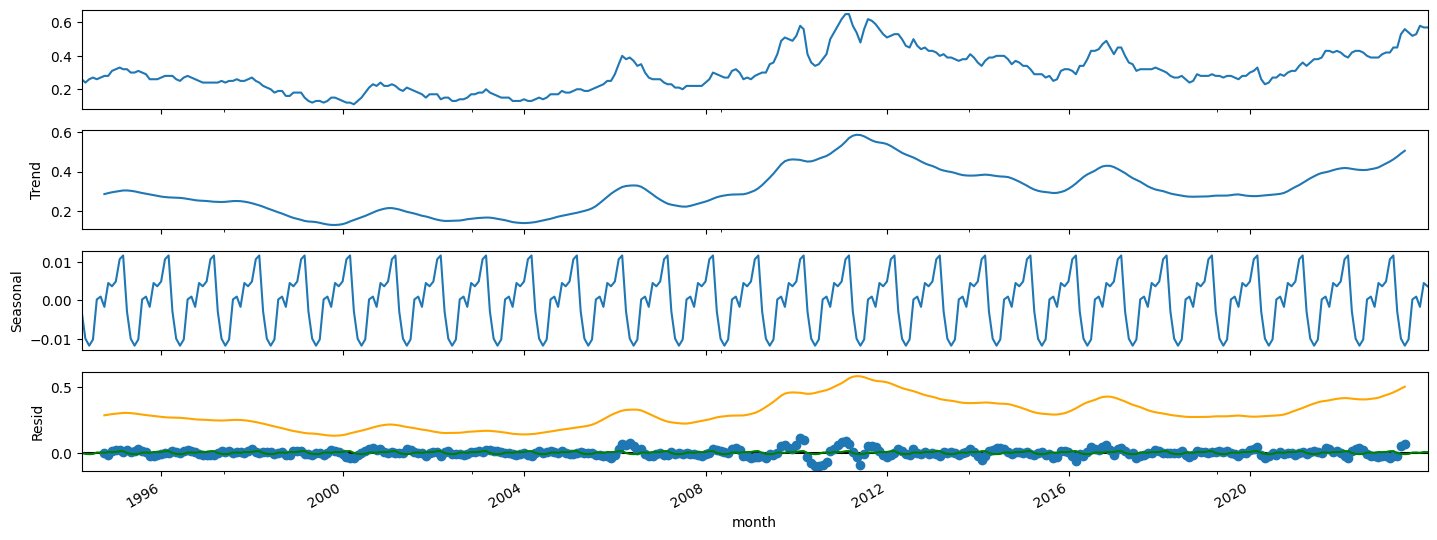

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Resample the time series data based on monthly 'M' frequency
df_month = df_eda.resample('M', on='month').mean()

# Create a bar graph for price
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_month['1992':].index, df_month.loc['1992':, "price"], width=25, align='center')

# Create a bar graph for change
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_month['1992':].index, df_month.loc['1992':, "change"], width=25, align='center')

# Plot the price difference
df_eda.price.diff(2).plot(figsize=(10, 6))

# Plot the change difference
df_eda.change.diff(2).plot(figsize=(10, 6))

# Create a 'Shift' column for price
df_eda['Shift'] = df_eda.price.div(df_eda.price.shift())
df_eda['Shift'].plot(figsize=(10, 8), fontsize=16)

# Create a 'Shift' column for change
df_eda['Shift'] = df_eda.change.div(df_eda.change.shift())
df_eda['Shift'].plot(figsize=(10, 8), fontsize=16)

# Decompose Seasonality
df_month

seasonal_data = df_month
seasonal_data.drop(columns=['change'], inplace=True)

decompose_seasonal_data = seasonal_decompose(seasonal_data, model="additive")
decompose_seasonal_data.plot();

trend = decompose_seasonal_data.trend
trend.plot(figsize=(16, 6), color='orange')

seasonality = decompose_seasonal_data.seasonal
seasonality.plot(figsize=(16, 6), color='green')


<ipython-input-8-a9d5e280b8aa>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_data = df_data.resample('4M', on='month').mean()


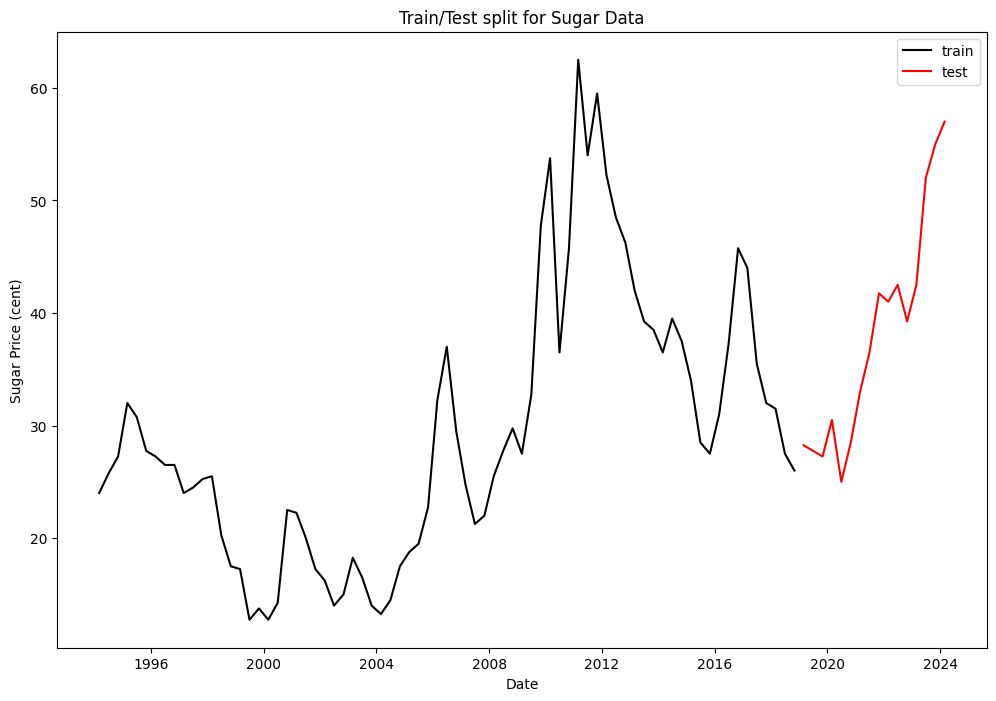

,price_cent
month,
1994-02-28,24.00
1994-06-30,25.75
1994-10-31,27.25
1995-02-28,32.00
1995-06-30,30.75
...,...
2022-10-31,39.25
2023-02-28,42.50
2023-06-30,52.00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'month' column to datetime format
df_data = df_table.copy()
df_data['month'] = pd.to_datetime(df_data['month'])
df_data.head()

# Change the 'price' column to cent units
df_data['price_dollar'] = '0' + df_data.price
df_data['price_cent'] = pd.to_numeric(df_data.price_dollar)
df_data['price_cent'] *= 100
df_data.drop(columns='price', inplace=True)
df_data.head()

# Resample the data every 4 months
df_data = df_data.resample('4M', on='month').mean()
df_data.head()

# Split the dataframe into training and testing data
df_train = df_data[df_data.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
df_test = df_data[df_data.index > pd.to_datetime("2018-12-31", format='%Y-%m-%d')]

# Plot the training and testing data
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train['price_cent'], color="black", label="train")
plt.plot(df_test.index, df_test['price_cent'], color="red", label="test")
plt.ylabel('Sugar Price (cent)')
plt.xlabel('Date')
plt.legend()
plt.title("Train/Test split for Sugar Data")
plt.show()
plt.close()

# Check the stationarity of the data
df_data

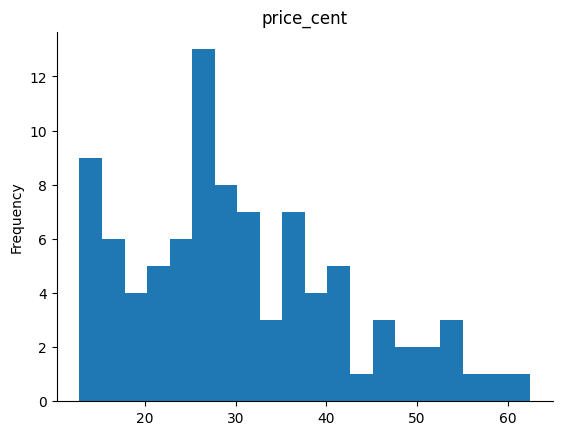

In [ ]:
# @title price_cent

from matplotlib import pyplot as plt
df_data['price_cent'].plot(kind='hist', bins=20, title='price_cent')
plt.gca().spines[['top', 'right',]].set_visible(False)

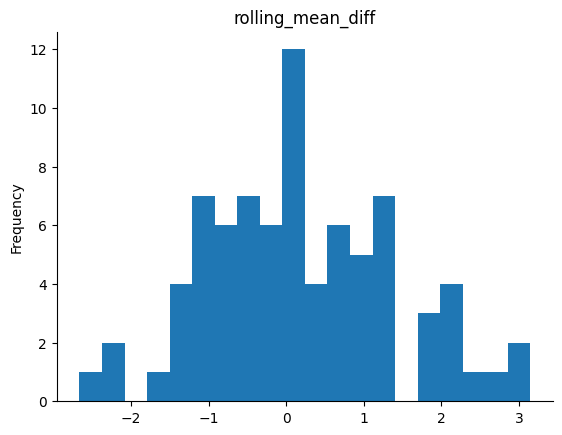

In [ ]:
# @title rolling_mean_diff

from matplotlib import pyplot as plt
df_data['rolling_mean_diff'].plot(kind='hist', bins=20, title='rolling_mean_diff')
plt.gca().spines[['top', 'right',]].set_visible(False)

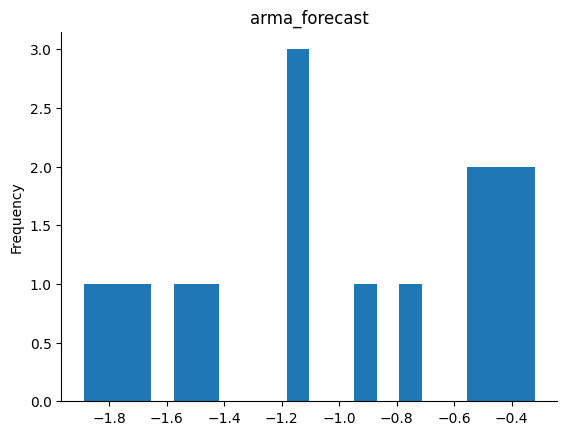

In [ ]:
# @title arma_forecast

from matplotlib import pyplot as plt
df_data['arma_forecast'].plot(kind='hist', bins=20, title='arma_forecast')
plt.gca().spines[['top', 'right',]].set_visible(False)

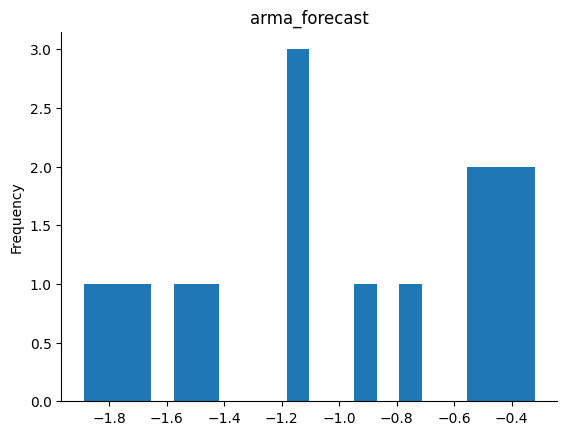

In [ ]:
# @title arma_forecast

from matplotlib import pyplot as plt
df_data['arma_forecast'].plot(kind='hist', bins=20, title='arma_forecast')
plt.gca().spines[['top', 'right',]].set_visible(False)

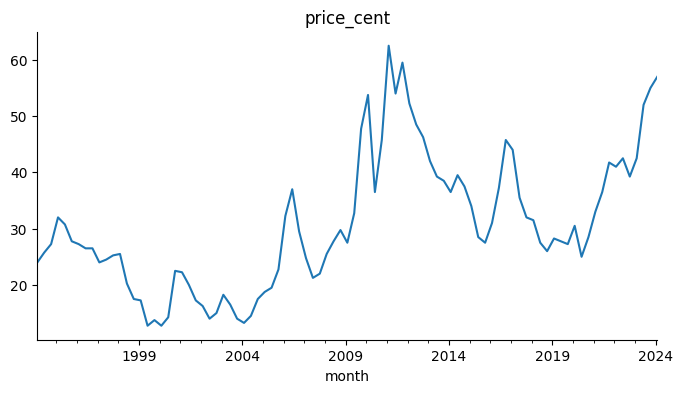

In [ ]:
# @title price_cent

from matplotlib import pyplot as plt
df_data['price_cent'].plot(kind='line', figsize=(8, 4), title='price_cent')
plt.gca().spines[['top', 'right']].set_visible(False)

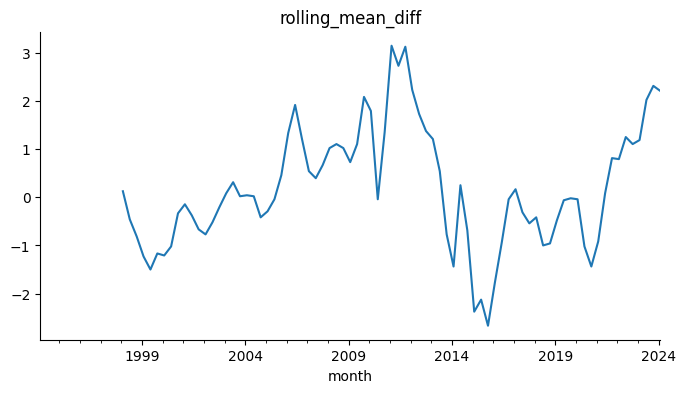

In [ ]:
# @title rolling_mean_diff

from matplotlib import pyplot as plt
df_data['rolling_mean_diff'].plot(kind='line', figsize=(8, 4), title='rolling_mean_diff')
plt.gca().spines[['top', 'right']].set_visible(False)

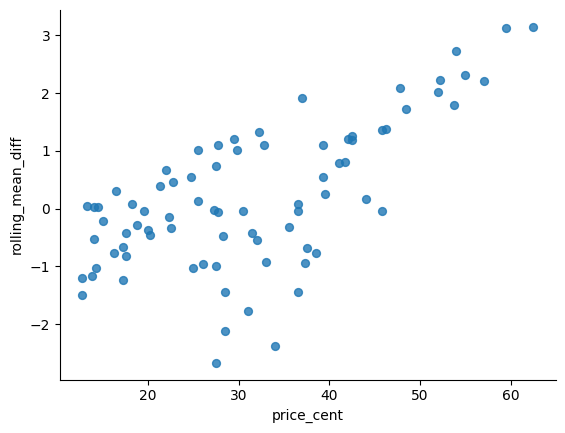

In [ ]:
# @title price_cent vs rolling_mean_diff

from matplotlib import pyplot as plt
df_data.plot(kind='scatter', x='price_cent', y='rolling_mean_diff', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

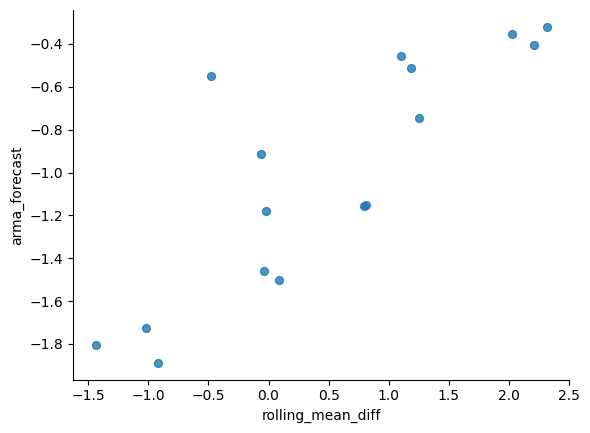

In [ ]:
# @title rolling_mean_diff vs arma_forecast

from matplotlib import pyplot as plt
df_data.plot(kind='scatter', x='rolling_mean_diff', y='arma_forecast', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

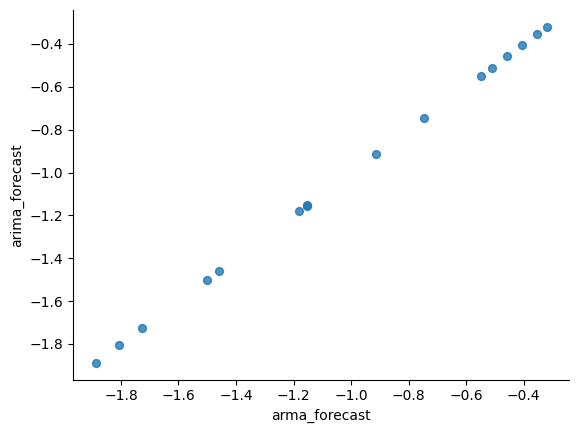

In [ ]:
# @title arma_forecast vs arima_forecast

from matplotlib import pyplot as plt
df_data.plot(kind='scatter', x='arma_forecast', y='arima_forecast', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Perform ADFuller test on the 'price_cent' column
dftest = adfuller(df_data['price_cent'], autolag='AIC')
print("1. ADF : ", dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation:", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t", key, ": ", val)

# Check if the data is non-stationary
# Apply rolling mean and differencing to make the data stationary
rolling_mean = df_data.rolling(window=12).mean()
df_data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()

# Perform ADFuller test again on the differenced data
dftest = adfuller(df_data['rolling_mean_diff'].dropna(), autolag='AIC')
print("1. ADF : ", dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation:", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t", key, ": ", val)

df_test_copy = df_test.copy()

1. ADF :  -1.068125280631077
2. P-Value :  0.7276143956770442
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 88
5. Critical Values :
	 1% :  -3.506944401824286
	 5% :  -2.894989819214876
	 10% :  -2.584614550619835
1. ADF :  -1.299686457864078
2. P-Value :  0.6293157473789175
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 66
5. Critical Values :
	 1% :  -3.5335601309235605
	 5% :  -2.9064436883991434
	 10% :  -2.590723948576676


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning

RMSE from ARMA: 14.097098115497499
RMSE from ARIMA: 14.097098115497499
R2-Squared from ARMA: -1.0258248510815817
R2-Squared from ARIMA: -1.0258248510815817
MAE from ARMA: 10.586841694630444
MAE from ARIMA: 10.586841694630444


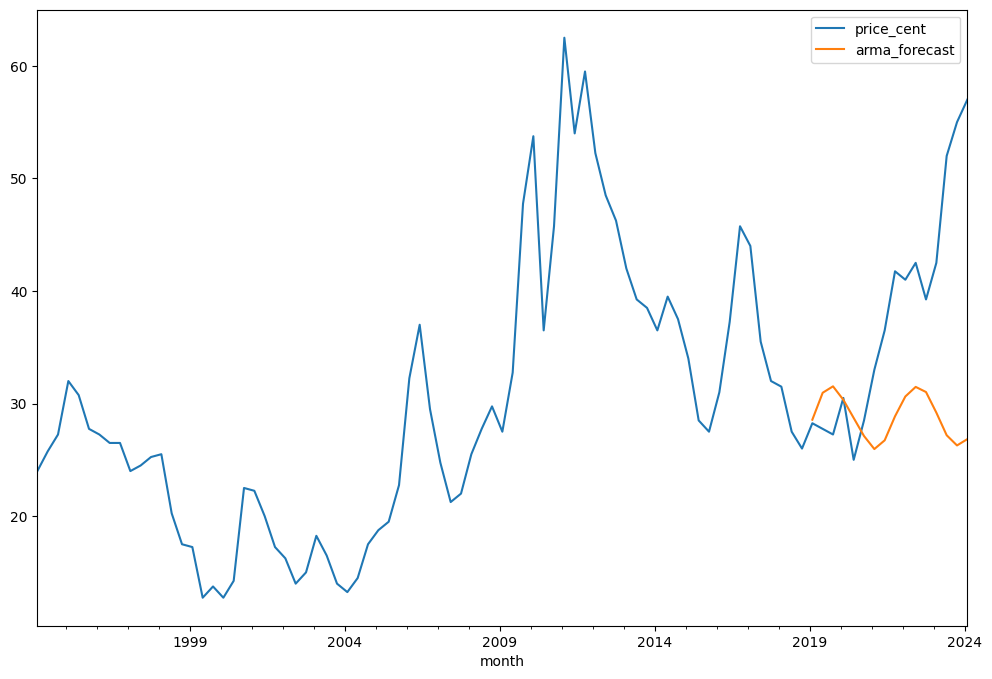

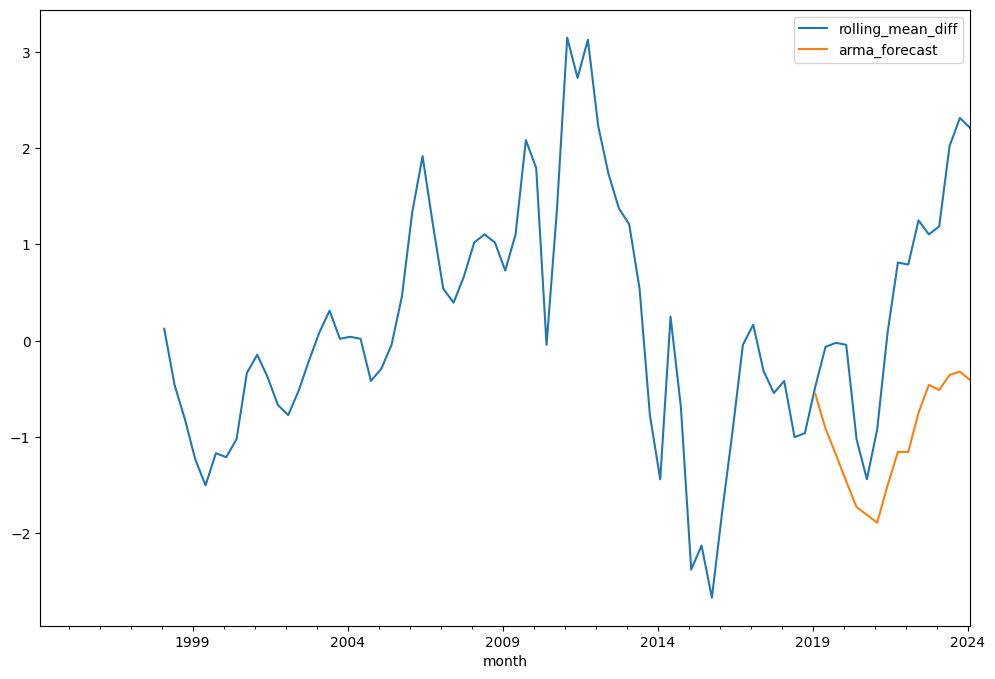

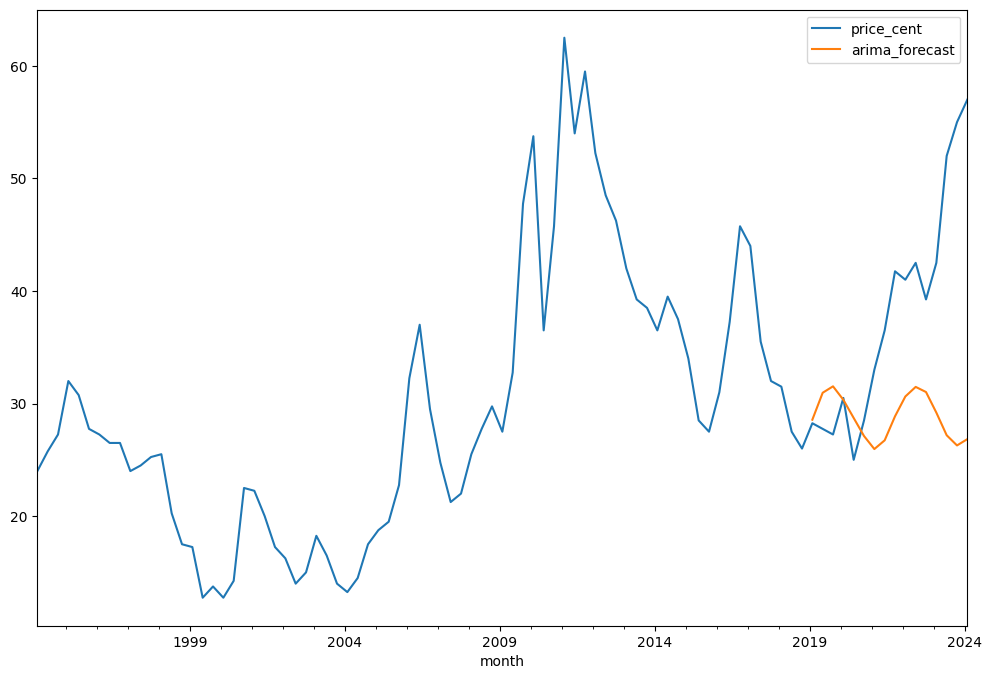

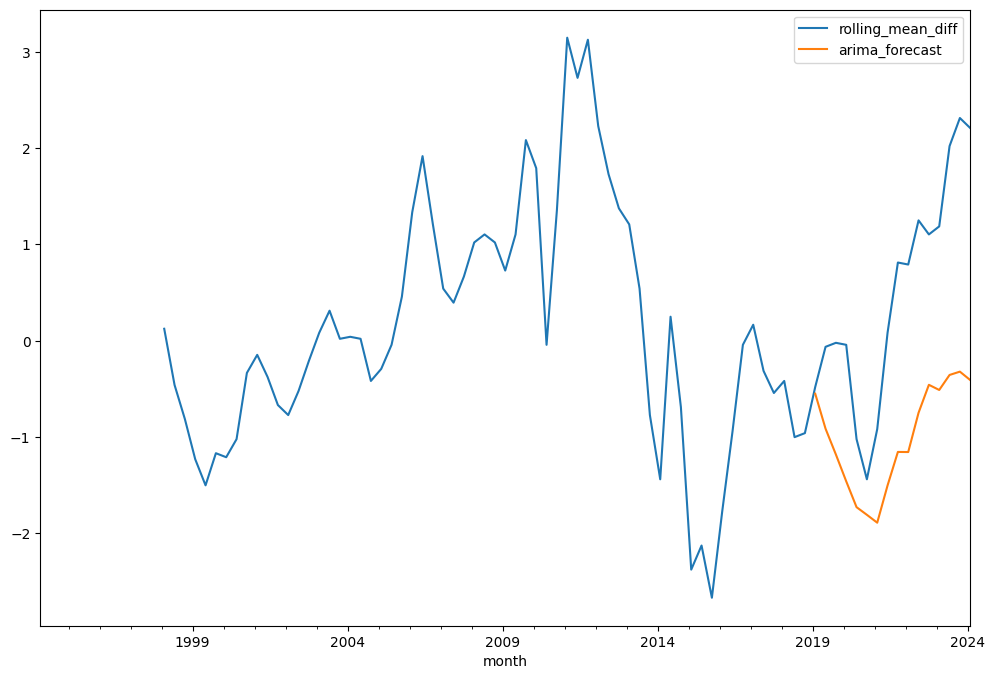

In [ ]:
# Attempt ARMA modeling
ARMAmodel_price = SARIMAX(df_train['price_cent'], order=(9, 1, 9))
ARMAmodel_price = ARMAmodel_price.fit()

arma_forecast = ARMAmodel_price.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=True)
df_data['arma_forecast'] = arma_forecast
df_data[['price_cent', 'arma_forecast']].plot(figsize=(12, 8))
df_test_copy['arma_forecast'] = arma_forecast

ARMAmodel_rolling = SARIMAX(df_data['rolling_mean_diff'], order=(9, 1, 9))
ARMAmodel_rolling = ARMAmodel_rolling.fit()

arma_forecast = ARMAmodel_rolling.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=True)
df_data['arma_forecast'] = arma_forecast
df_data[['rolling_mean_diff', 'arma_forecast']].plot(figsize=(12, 8))

# Attempt ARIMA modeling
ARIMAmodel = SARIMAX(df_train['price_cent'], order=(9, 1, 9))
ARIMAmodel = ARIMAmodel.fit()

arima_forecast = ARIMAmodel.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=True)
df_data['arima_forecast'] = arima_forecast
df_data[['price_cent', 'arima_forecast']].plot(figsize=(12, 8))
df_test_copy['arima_forecast'] = arima_forecast

ARIMAmodel_rolling = SARIMAX(df_data['rolling_mean_diff'], order=(9, 1, 9))
ARIMAmodel_rolling = ARIMAmodel_rolling.fit()

arima_forecast = ARIMAmodel_rolling.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=True)
df_data['arima_forecast'] = arima_forecast
df_data[['rolling_mean_diff', 'arima_forecast']].plot(figsize=(12, 8))

# Evaluate RMSE
arma_rmse = np.sqrt(mean_squared_error(df_test_copy['price_cent'], df_test_copy['arma_forecast']))
arima_rmse = np.sqrt(mean_squared_error(df_test_copy['price_cent'], df_test_copy['arima_forecast']))

print("RMSE from ARMA:", arma_rmse)
print("RMSE from ARIMA:", arima_rmse)


# Evaluate R2-Squared
arma_r2_score = r2_score(df_test_copy['price_cent'], df_test_copy['arma_forecast'])
arima_r2_score = r2_score(df_test_copy['price_cent'], df_test_copy['arima_forecast'])


print("R2-Squared from ARMA:", arma_r2_score)
print("R2-Squared from ARIMA:", arima_r2_score)


# Evaluate MAE
arma_mae = mean_absolute_error(df_test_copy['price_cent'], df_test_copy['arma_forecast'])
arima_mae = mean_absolute_error(df_test_copy['price_cent'], df_test_copy['arima_forecast'])


print("MAE from ARMA:", arma_mae)
print("MAE from ARIMA:", arima_mae)
